In [289]:
import cv2
import os
import random
import shutil
import pathlib
import itertools
import concurrent.futures
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from keras import models
from keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from IPython.core.display import Image
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD
from imblearn.over_sampling import RandomOverSampler 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import textwrap as tw
from pathlib import Path
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import auc,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import tensorflow_datasets as tfds
from PIL import Image, ImageEnhance
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder
import joblib

In [175]:
train = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

train_df = pd.DataFrame(columns=['FilePaths', 'Labels'])
test_df = pd.DataFrame(columns=['FilePaths', 'Labels'])


In [178]:
#for label, directory in enumerate(os.listdir(train)):
    #for filename in os.listdir(os.path.join(train, directory)):
        #image_path = os.path.join(train, directory, filename)
        #train_df = train_df.append({'FilePaths': image_path, 'Labels': label}, ignore_index=True)

#for label, directory in enumerate(os.listdir(test)):
    #for filename in os.listdir(os.path.join(test, directory)):
        #image_path = os.path.join(test, directory, filename)
        #test_df = test_df.append({'FilePaths': image_path, 'Labels': label}, ignore_index=True)

In [177]:
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,FilePaths,Labels
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
...,...,...
2352,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2353,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2354,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2355,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8


In [179]:
labels = os.listdir(train)

label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

In [163]:
print('Train : ', df.shape)
df['Labels'].value_counts(ascending=True)

Train :  (2357, 2)


6     80
7    111
3    130
2    142
4    197
8    373
5    392
1    454
0    478
Name: Labels, dtype: int64

In [180]:
max_images_per_class = 500
df = df.groupby("Labels").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

/tmp/ipykernel_32/909940718.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("Labels").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [181]:
max_workers = multiprocessing.cpu_count()
max_workers

4

In [183]:
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))


with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, df['FilePaths'].tolist()))

df['image'] = image_arrays
del image_arrays
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2357
Name: image, dtype: int64

In [186]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['Labels'], shuffle=True)

print('Train: ', df_train.shape)
print('Test: ', df_test.shape)

Train:  (1649, 3)
Test:  (708, 3)


In [189]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [193]:
model_df = pd.DataFrame(columns=['FilePaths', 'Labels', 'image'])


for class_label in df_train['Labels'].unique():
    image_arrays = df_train.loc[df_train['Labels'] == class_label, 'image'].values
    
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            
            model_images = datagen.flow(image_tensor, batch_size=1)
            
            
            for i in range(model_images.n):
                model_image_array = model_images.next()[0].astype('uint8')
                model_df = model_df.append({'FilePaths': None, 'Labels': class_label, 'image': model_image_array}, ignore_index=True)
    
    original_images_df = df_train.loc[df_train['Labels'] == class_label, ['FilePaths', 'Labels', 'image']]
    model_df = model_df.append(original_images_df, ignore_index=True)

df_train = model_df.groupby('Labels').head(max_images_per_class)

del model_df

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_32/2759592470.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_df = model_df.append(original_images_df, ignore_index=True)
/tmp/ipykernel_32/2759592470.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_df = model_df.append(original_images_df, ignore_index=True)
/tmp/ipykernel_32/2759592470.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_df = model_df.append(original_images_df, ignore_index=True)
/tmp/ipykernel_32/2759592470.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_df = model_df.append(original_images_df, ignore_index=True)
/tmp/ipykernel_32/2759592470.py:23: FutureWarning: T

In [194]:
class_counts = df_train['Labels'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     500       
1               melanoma                       500       
2               vascular lesion                500       
3               actinic keratosis              500       
4               squamous cell carcinoma        500       
5               basal cell carcinoma           500       
6               seborrheic keratosis           500       
7               dermatofibroma                 500       
8               nevus                          500       
------------------------------------------------------------
Total                                         4500      


In [197]:
x = df_train.drop(columns=['FilePaths','Labels'],axis=1)
y = df_train['Labels']

xt = df_test.drop(columns=['FilePaths','Labels'],axis=0)
yt = df_test['Labels']

In [198]:
print(x.shape,y.shape)
print(xt.shape,yt.shape)

(4500, 1) (4500,)
(708, 1) (708,)


In [199]:
xtrain = np.asarray(x['image'].tolist())
xtest = np.asarray(xt['image'].tolist())

xtrain_mean = np.mean(xtrain)
xtrain_std = np.std(xtrain)
xtest_mean = np.mean(xtest)
xtest_std = np.std(xtest)

xtrain = (xtrain - xtrain_mean)/xtrain_std
xtest = (xtest - xtest_mean)/xtest_std

ytrain = to_categorical(y,num_classes = num_classes)
ytest = to_categorical(yt,num_classes = num_classes)

In [200]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, stratify=ytrain, test_size = 0.2,shuffle=True)
print('Train Data: ', xtrain.shape)
print('Val Data: ', xval.shape)

Train Data:  (3600, 75, 100, 3)
Val Data:  (900, 75, 100, 3)


In [201]:
xtrain = xtrain.reshape(xtrain.shape[0], *(75, 100, 3))
xtest = xtest.reshape(xtest.shape[0], *(75, 100, 3))
xval = xval.reshape(xval.shape[0], *(75, 100, 3))
xtest.shape
(708, 75, 100, 3)
ytrain = ytrain.astype(int)
yval = yval.astype(int)

In [203]:
train_counts = np.sum(ytrain, axis=0)
val_counts = np.sum(yval, axis=0)
test_counts = np.sum(ytest, axis=0)

print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(ytrain):<10} {len(yval):<12} {len(ytest):<10} {len(ytrain) + len(yval) + len(ytest):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     400        100          144        644       
1               melanoma                       400        100          136        636       
2               vascular lesion                400        100          43         543       
3               actinic keratosis              400        100          39         539       
4               squamous cell carcinoma        400        100          59         559       
5               basal cell carcinoma           400        100          118        618       
6               seborrheic keratosis           400        100          24         524       
7               dermatofibroma                 400        

In [263]:
img_size = df_train['image'][0].shape
print(img_size)

(75, 100, 3)


In [264]:
base_model = EfficientNetB4(weights='imagenet',include_top=False, input_shape=img_size)

for layer in base_model.layers[436:467]:
        layer.trainable = True

model = models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 3, 4, 1792)       17673823  
                                                                 
 flatten_8 (Flatten)         (None, 21504)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 21504)            86016     
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 21504)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               11010560  
                                                                 
 dense_17 (Dense)            (None, 9)                 4617      
                                                     

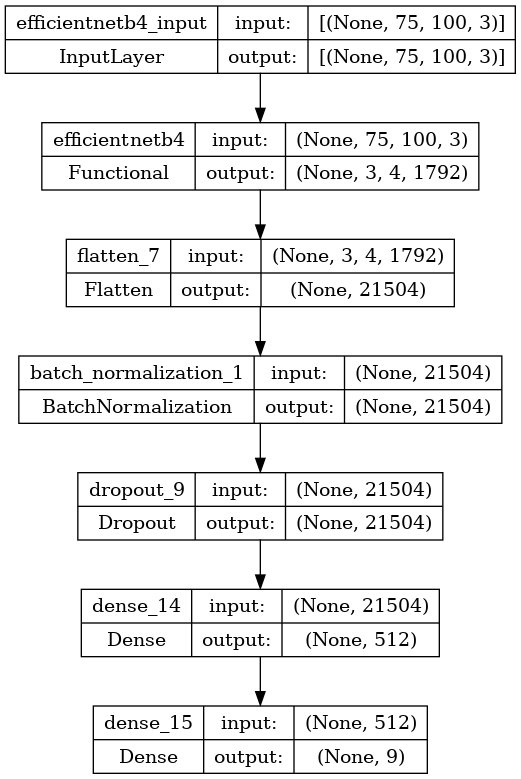

In [226]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [266]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics = ['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
checkpoint = ModelCheckpoint(
    filepath='Skin_Cancer_ISIC.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    restore_best_weights=True,
    patience=10,
    verbose=1
)

In [269]:
epochs = 32
batch_size= 64
hst = model.fit(
    x=xtrain, 
    y=ytrain,
    validation_data = (xval,yval),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/32
57/57 [==============================] - 322s 6s/step - loss: 2.4252 - accuracy: 0.2658 - val_loss: 2.9990 - val_accuracy: 0.1044
Epoch 2/32
57/57 [==============================] - 310s 5s/step - loss: 1.8266 - accuracy: 0.4344 - val_loss: 2.4136 - val_accuracy: 0.1422
Epoch 3/32
57/57 [==============================] - 320s 6s/step - loss: 1.5027 - accuracy: 0.5178 - val_loss: 3.1272 - val_accuracy: 0.1133
Epoch 4/32
57/57 [==============================] - 316s 6s/step - loss: 1.2472 - accuracy: 0.5803 - val_loss: 4.1121 - val_accuracy: 0.1133
Epoch 5/32
57/57 [==============================] - 318s 6s/step - loss: 1.0708 - accuracy: 0.6261 - val_loss: 3.9089 - val_accuracy: 0.1378
Epoch 6/32
57/57 [==============================] - 317s 6s/step - loss: 0.9225 - accuracy: 0.6781 - val_loss: 3.4666 - val_accuracy: 0.2133
Epoch 7/32
57/57 [==============================] - 316s 6s/step - loss: 0.7711 - accuracy: 0.7286 - val_loss: 3.0922 - val_accuracy: 0.1956
Epoch 8/32
57

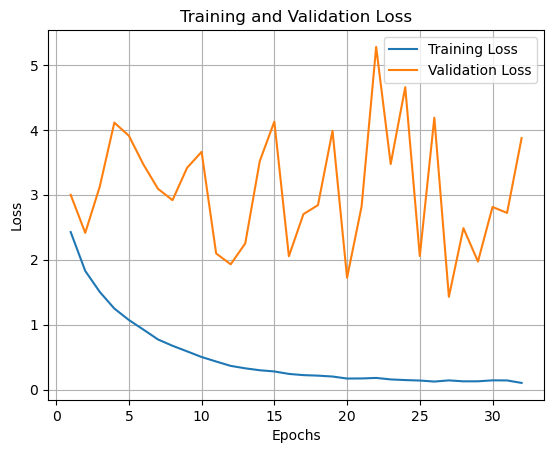

In [272]:
train_loss = hst.history['loss']
val_loss = hst.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

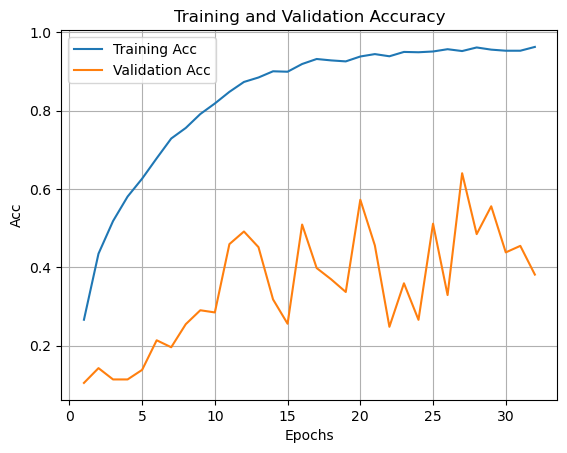

In [273]:
train_accuracy = hst.history['accuracy']
val_accuracy = hst.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()


In [280]:
model.save_weights("Skin_Cancer_ISIC.h5")
print("Model saved successfully!")

Model saved successfully!


In [281]:
model.load_weights("Skin_Cancer_ISIC.h5")

<Figure size 640x480 with 0 Axes>

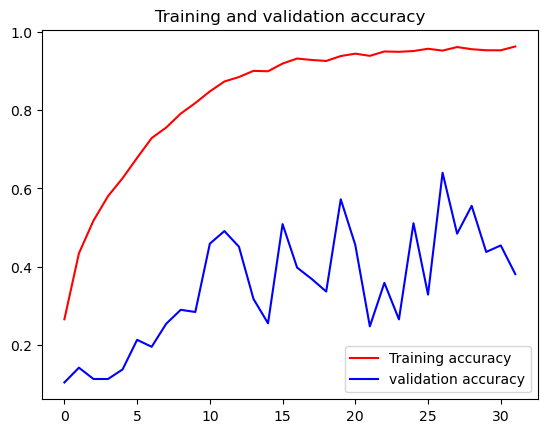

<Figure size 640x480 with 0 Axes>

In [282]:
%matplotlib inline 
import matplotlib.pyplot as plt
acc = hst.history['accuracy']
val_acc = hst.history['val_accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc= 0)
plt.figure()

In [285]:
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

113/113 [==============================] - 59s 522ms/step - loss: 3.5241 - accuracy: 0.4400
Train: accuracy = 0.440000  ;  loss = 3.524053


In [286]:
loss, accuracy = model.evaluate(xtest, ytest, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

23/23 [==============================] - 15s 499ms/step - loss: 3.7700 - accuracy: 0.4110
Testing: accuracy = 0.411017  ;  loss = 3.770001


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 15s 498ms/step


<Axes: >

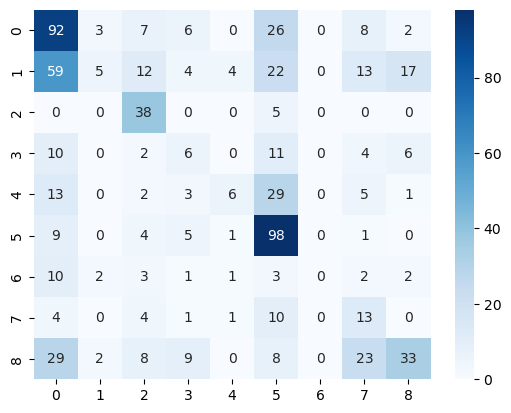

In [287]:
ypred_prob = model.predict(xtest)

ypred = np.argmax(ypred_prob, axis=1)

cm = confusion_matrix(np.argmax(ytest, axis=1), ypred)

sns.heatmap(cm, annot=True, cmap='Blues')

In [292]:
ytrue = np.array(ytest)
ypred = model.predict(xtest)

ypred = np.argmax(ypred , axis=1)
ytrue = np.argmax(ytrue , axis=1)

23/23 [==============================] - 12s 498ms/step
